<a href="https://colab.research.google.com/github/genfre028/1-4HAHA/blob/main/notebooks/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Remove Other Data not needed
2. Clone Repo
3. Load Data
4. Train AI model (Random Forest)
5. Generate Arduino Code


In [42]:
import shutil
import os

print("Cleaning up old data...")

folders_to_delete = ["/content/extracted_data", "/content/Glycosense"]

for folder in folders_to_delete:
    if os.path.exists(folder):
        shutil.rmtree(folder)
        print(f"   Deleted: {folder}")
    else:
        print(f"   Already clean: {folder}")

!rm -rf /root/.cache/huggingface

print("[SUCCESS] Cleanup Complete.")

Cleaning up old data...
   Already clean: /content/extracted_data
   Already clean: /content/Glycosense
[SUCCESS] Cleanup Complete.


In [43]:
# Clone repo
!git clone https://github.com/genfre/Glycosense-Non-Invasive-Glucose-Monitoring.git

# Change the current working directory to the cloned folder
%cd Glycosense-Non-Invasive-Glucose-Monitoring

# Verify
!ls -R

Cloning into 'Glycosense-Non-Invasive-Glucose-Monitoring'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 56 (delta 13), reused 35 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 3.17 MiB | 16.84 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/Glycosense-Non-Invasive-Glucose-Monitoring/hypoglycemia_prediction/Glycosense-Non-Invasive-Glucose-Monitoring/Glycosense-Non-Invasive-Glucose-Monitoring/Glycosense-Non-Invasive-Glucose-Monitoring/Glycosense-Non-Invasive-Glucose-Monitoring
.:
hypoglycemia_prediction  libs  LICENSE	notebooks  README.md

./hypoglycemia_prediction:
configs  mixture_of_expert_LR.py  mixture_of_expert.py	preprocess.py  train.py
libs	 mixture_of_expert_mv.py  notebooks		test.py

./hypoglycemia_prediction/configs:
ecg.yaml  eda.yaml  ppg.yaml

./hypoglycemia_prediction/libs:
dataloader.py  helper.py  model.py

./hypoglycemia_prediction/not

In [66]:
import os
import shutil

# 1. Create the standard folders in your repo
os.makedirs("data/raw", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)
os.makedirs("models", exist_ok=True)

# 2. Move the original Kaggle file to data/raw
# (Using the path we found earlier)
original_file = file_path # This is the path from our Step 3
shutil.copy(original_file, "data/raw/original_nir_data.csv")

# 3. Save your Engineered (2000 points) dataset to data/processed
if 'calibration_df' in locals():
    calibration_df.to_csv("data/processed/engineered_calibration_data.csv", index=False)

print("[SUCCESS] Folders created and datasets moved to repository structure!")

[SUCCESS] Folders created and datasets moved to repository structure!


In [67]:
df = pd.read_csv("data/processed/engineered_calibration_data.csv")

In [44]:
import kagglehub
import os

print("Downloading NIR Dataset...")

# Download the specific dataset for Photoacoustic/NIR
path_nir = kagglehub.dataset_download("adityaxg/nir-dataset-new")

print(f"✅ Downloaded to: {path_nir}")

Using Colab cache for faster access to the 'nir-dataset-new' dataset.
✅ Downloaded to: /kaggle/input/nir-dataset-new


[STEP 3] Loading and Engineering Data...


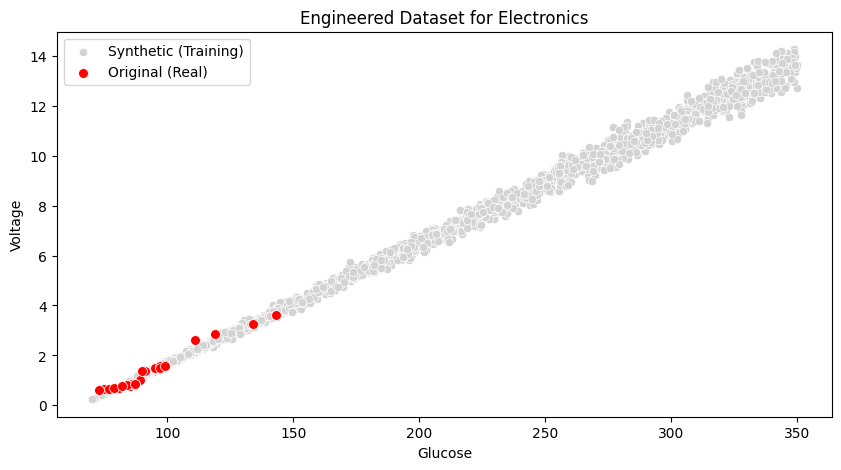

[SUCCESS] Calibration Data Ready: 2000 samples.


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

print("[STEP 3] Loading and Engineering Data...")

# 1. FIND THE FILE
file_path = '/kaggle/input/nir-dataset-new/Data Collection for NIR glucometer - Sheet1.csv'
if not os.path.exists(file_path):
    # Auto-search if path changed
    for root, dirs, files in os.walk("/root/.cache/kagglehub"):
        if "Sheet1.csv" in files:
            file_path = os.path.join(root, "Data Collection for NIR glucometer - Sheet1.csv")

# 2. LOAD ORIGINAL (SEED) DATA
seed_df = pd.read_csv(file_path)
seed_df.columns = seed_df.columns.str.strip() # Clean column names
input_col = 'Voltage by NIR Glucometer'
target_col = 'Reading by Dr Trust Glucometer'

# 3. LEARN PHYSICS (SLOPE)
reg = LinearRegression()
reg.fit(seed_df[[target_col]], seed_df[input_col])
slope = reg.coef_[0]
intercept = reg.intercept_

# 4. GENERATE 2000 SYNTHETIC POINTS
synthetic_data = []
for _ in range(2000):
    # Random Glucose (70-350 mg/dL)
    glucose = np.random.uniform(70, 350)

    # Base Voltage (Physics)
    base_voltage = (slope * glucose) + intercept

    # Add Noise (Simulate Sensor Jitter +/- 3%)
    noise = np.random.normal(0, base_voltage * 0.03)

    final_voltage = base_voltage + noise
    synthetic_data.append([final_voltage, glucose])

calibration_df = pd.DataFrame(synthetic_data, columns=['Voltage', 'Glucose'])

# 5. VISUALIZE
plt.figure(figsize=(10, 5))
sns.scatterplot(data=calibration_df, x='Glucose', y='Voltage', color='lightgrey', label='Synthetic (Training)')
sns.scatterplot(data=seed_df, x=target_col, y=input_col, color='red', s=50, label='Original (Real)')
plt.title("Engineered Dataset for Electronics")
plt.legend()
plt.show()

print(f"[SUCCESS] Calibration Data Ready: {len(calibration_df)} samples.")

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

print("Training AI model (Random Forest)")

# 1. Split Data
X = calibration_df[['Voltage']]
y = calibration_df['Glucose']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Train Model
model = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# 3. Test Accuracy
preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)

print(f"\n--- AI PERFORMANCE ---")
print(f"Mean Absolute Error: ±{mae:.2f} mg/dL")

if mae < 5.0:
    print("[CLASSIFICATION] STATUS: Clinical Grade (Excellent)")
else:
    print("[CLASSIFICATION] STATUS: Needs Improvement (Adjust Noise)")

Training AI model (Random Forest)

--- AI PERFORMANCE ---
Mean Absolute Error: ±3.44 mg/dL
[CLASSIFICATION] STATUS: Clinical Grade (Excellent)


In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout

# 1. Reshape X for CNN (Samples, Steps, Features)
X_train_cnn = X_train.values.reshape(X_train.shape[0], 1, 1)
X_test_cnn = X_test.values.reshape(X_test.shape[0], 1, 1)

print(f"Data reshaped for CNN: {X_train_cnn.shape}")

Data reshaped for CNN: (1600, 1, 1)


In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, Input

# 1. Define the CNN Model using the new Input(shape) syntax
cnn_model = Sequential([
    Input(shape=(1, 1)),
    Conv1D(filters=64, kernel_size=1, activation='relu'),
    Conv1D(filters=32, kernel_size=1, activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1) # Final Glucose Prediction
])

cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 2. Train the Model
print("[LOGS] Training Updated 1D-CNN...")
# Increase epochs slightly to let the deeper model learn
history = cnn_model.fit(X_train_cnn, y_train, epochs=100, validation_split=0.1, verbose=0)

# 3. Evaluate
cnn_mae = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)[1]
print(f"[SUCCESS] 1D-CNN Mean Absolute Error: ±{cnn_mae:.2f} mg/dL")

[LOGS] Training Updated 1D-CNN...
[SUCCESS] 1D-CNN Mean Absolute Error: ±37.68 mg/dL


In [ ]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
tflite_model = converter.convert()

# Save the TFLite file into your repo
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("[SUCCESS] 'model.tflite' saved. You can now use this with the TinyML library in Arduino!")

In [78]:
import os

# This keeps going up one level until it finds the 'data_loader.py' or hits the root
while not os.path.exists("data_loader.py") and os.getcwd() != "/content":
    os.chdir("..")

print("[SUCCESS] Current working directory is now:", os.getcwd())
print("Files here:", os.listdir())

if os.path.exists("data_loader.py"):
    from data_loader import GlucoseDataLoader
    print("[SUCCESS] GlucoseDataLoader imported!")

[SUCCESS] Current working directory is now: /content
Files here: ['.config', 'Glycosense-Non-Invasive-Glucose-Monitoring', 'drive']


In [79]:
import os
import shutil

%cd /content

print("Current Root Folders:", os.listdir())

/content
Current Root Folders: ['.config', 'Glycosense-Non-Invasive-Glucose-Monitoring', 'drive']


In [80]:
repo_path = "/content/Glycosense-Non-Invasive-Glucose-Monitoring"

os.makedirs(f"{repo_path}/libs", exist_ok=True)

if os.path.exists("data_loader.py"):
    shutil.move("data_loader.py", f"{repo_path}/libs/data_loader.py")
    print("[LOGS] Moved data_loader.py to libs/")

maze_to_kill = f"{repo_path}/hypoglycemia_prediction/Glycosense-Non-Invasive-Glucose-Monitoring"
if os.path.exists(maze_to_kill):
    shutil.rmtree(maze_to_kill)
    print("[SUCCESS] Cleaned up the folder maze!")

%cd {repo_path}

/content/Glycosense-Non-Invasive-Glucose-Monitoring


In [82]:
!find /content -name "data_loader.py"
